This isn't actually an ARIMAX, it's a linear regression with ARIMA fit to residuals. This is easy to interpret, see here: http://robjhyndman.com/hyndsight/arimax/. However, I'm not sure if it's actually valid with linear regression. Hence will probably have to switch to actual ARIMAX or tranfer function model.

In [1]:
library(forecast)

Loading required package: zoo

Attaching package: 'zoo'

The following objects are masked from 'package:base':

    as.Date, as.Date.numeric

Loading required package: timeDate
This is forecast 7.1 



In [2]:
library(astsa)


Attaching package: 'astsa'

The following object is masked from 'package:forecast':

    gas



In [3]:
library(zoo)

In [4]:
preprocessing <- function(ts_csv, total_csv){
    
    # removes rows with low observations and locfs them
    # returns time series and total time series, as a list
    
    ts = read.csv(ts_csv)
    total <- read.csv(total_csv)
    df = data.frame(ts)
    df_total = data.frame(total)
    
    missing = df_total[,'total']<5000
    df_total[missing, 'total'] <- NA
    df[missing,] <-NA
    ts_total = ts(na.locf(df_total[,'total']))
    ts_filled = ts(na.locf(df[, ncol(df)]))
    return(list(series=ts_filled, total=ts_total))
}

In [90]:
fit_with_stl <- function(ts, total){
    # linear regression with total as independent and ts and dependent, then stl on residuals
    lin_fit = lm(ts~total)
    res = ts(lin_fit$residuals, frequency=24)
    stl_fit = stl(res, s.window='periodic')
    stl_remainder = stl_fit$time.series[,'remainder']
    return(stl_remainder)
}

In [31]:
dsarima <- function(ts, total){
    percent = ts/total
    plot(log(percent))
    transformed = diff(diff(log(ts/total), 168), 24)
    tsdisplay(transformed, lag.max=200)
    acf2(transformed, 200)
    fit = auto.arima(transformed)
    return(fit)
    
}

In [5]:
residual_analysis <- function(res){
    tsdisplay(res, lag.max=200)
#     tsdiag(res, gof.lag=20)
    dev.copy(png, 'juneqq.png')
    qqnorm(res)
    dev.off()
    dev.copy(png, 'juneresdensity.png')
    plot(density(res))
    dev.off()
    
}

In [7]:
dsarima2 <- function(ts, total){
#     dev.copy(png, 'junepercent.png')
    percent = ts/total
    plot(log(percent))
#     dev.off()

    
#     dev.copy(png, 'junetransformed.png')
    transformed = diff(diff(log(ts/total), 168), 24)
    tsdisplay(transformed, lag.max=200)
#     dev.off()
#     dev.copy(png, 'juneacf.png')
    acf2(transformed, 200)
#     dev.off()
    fit = arima(transformed, order = c(2, 0, 2), seasonal = list(order = c(2, 0, 2), period=24))
    return(fit)
    }

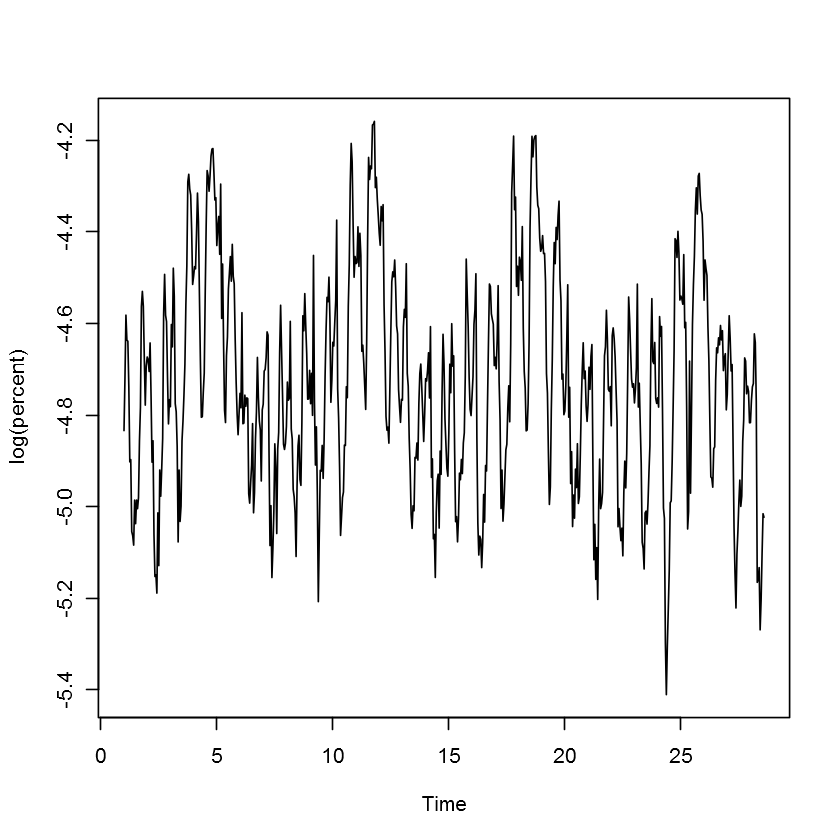

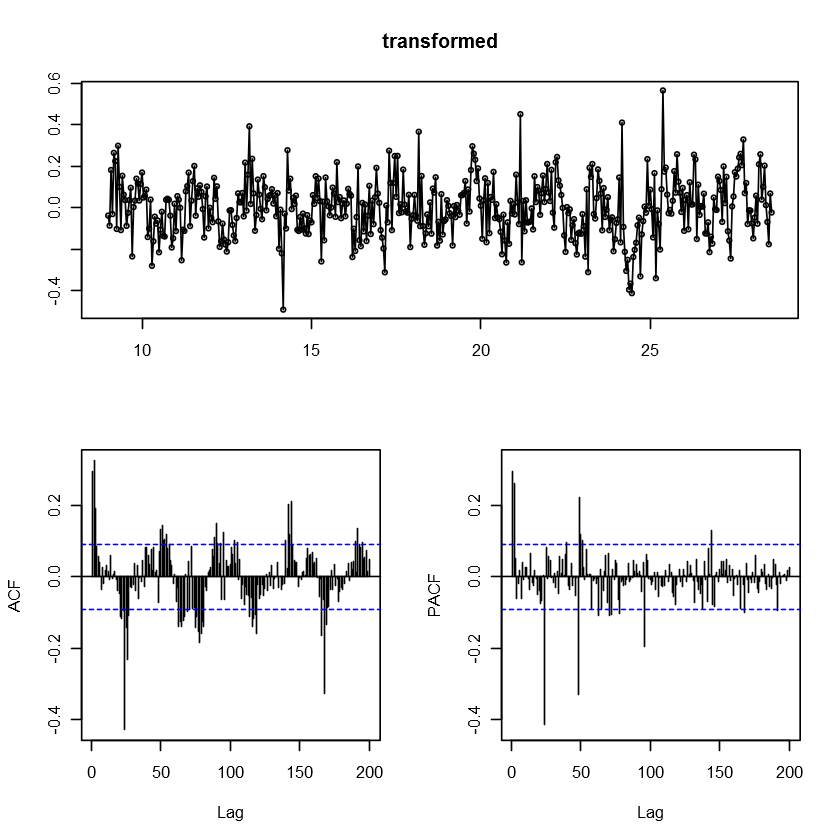

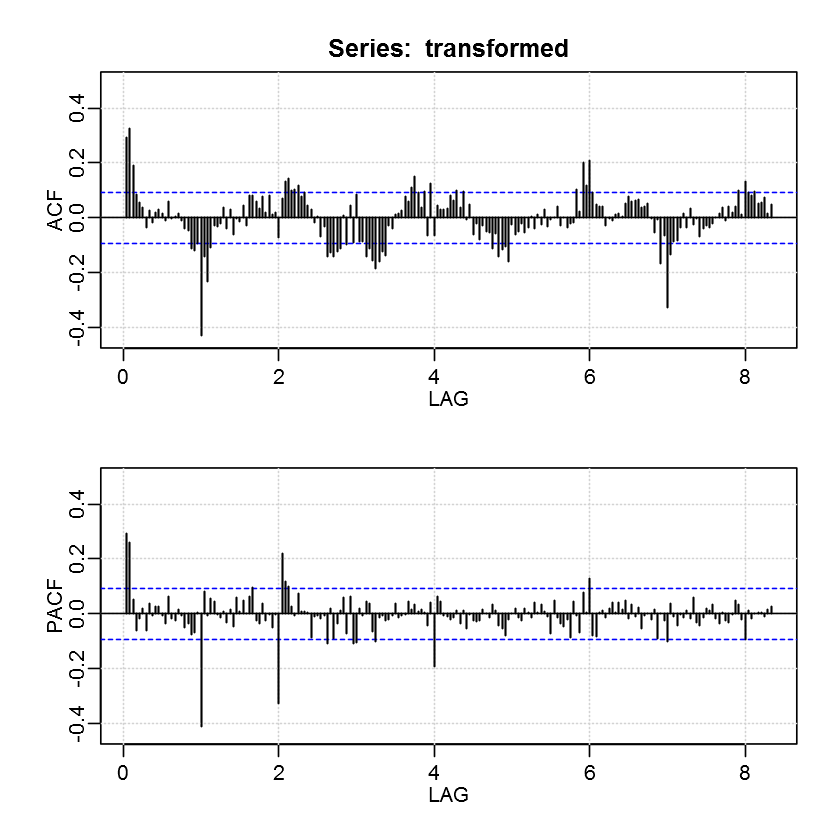

In [10]:

fit = dsarima2(ts_cas, ts_total)


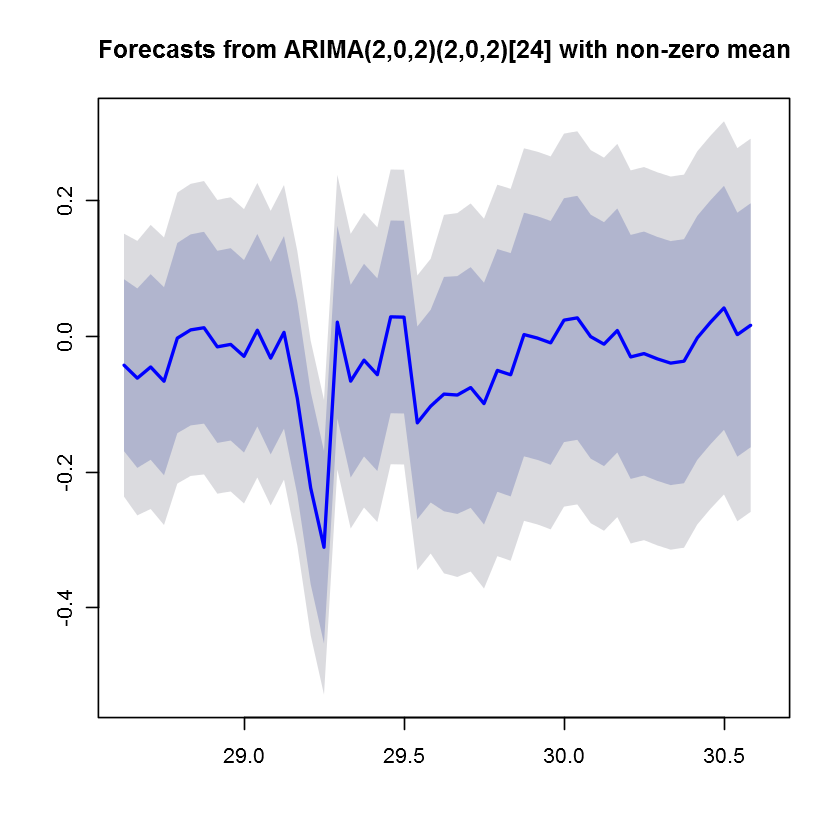

In [13]:
plot(forecast(fit))

In [11]:
fit


Call:
arima(x = transformed, order = c(2, 0, 2), seasonal = list(order = c(2, 0, 2), 
    period = 24))

Coefficients:
          ar1     ar2     ma1      ma2     sar1     sar2     sma1     sma2
      -0.1290  0.6911  0.4289  -0.3754  -0.5379  -0.1859  -0.2415  -0.3717
s.e.   0.1527  0.1337  0.1680   0.1200   0.1315   0.0764   0.1316   0.1248
      intercept
        -0.0044
s.e.     0.0029

sigma^2 estimated as 0.009793:  log likelihood = 408.22,  aic = -796.43

png 
  2

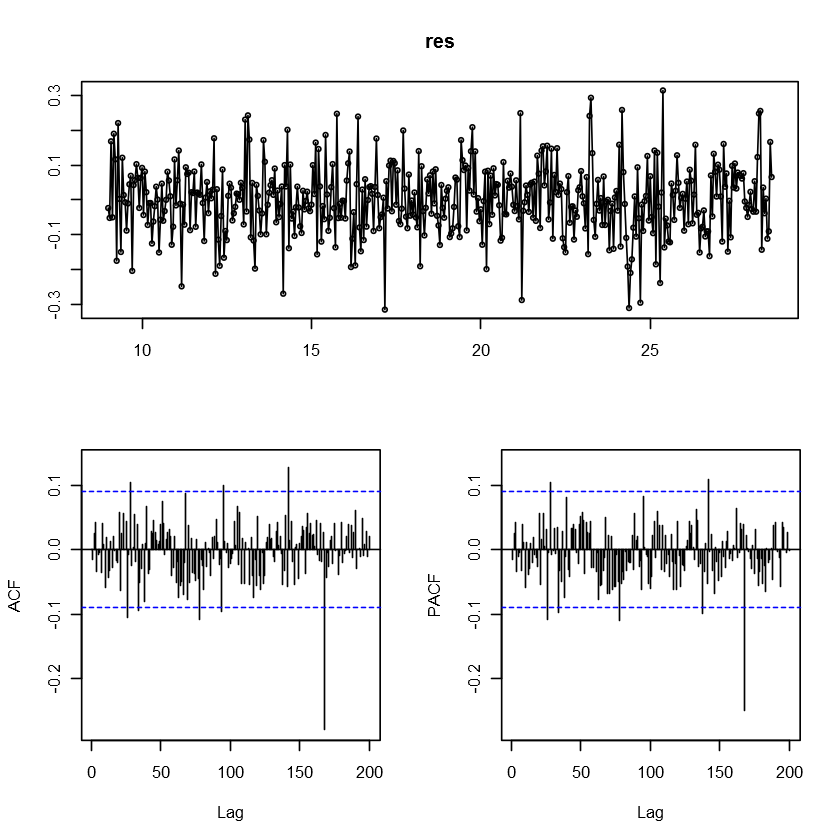

In [112]:
residual_analysis(fit$residual)

png 
  5

png 
  2

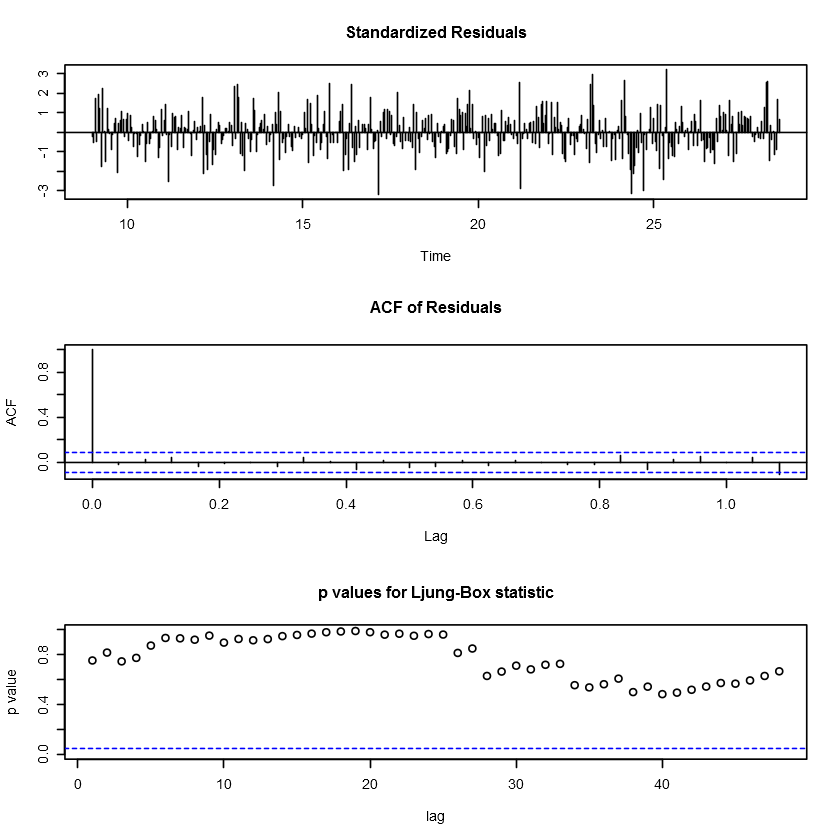

In [104]:
tsdiag(fit, gof.lag=48)
dev.copy(png, 'june202202res2.png')
dev.off()

In [8]:
results = preprocessing('E:/summary/june_casual.csv', 'E:/summary/june_total.csv')

In [9]:
ts_total = ts(results$total[49:711], frequency=24)
ts_cas = ts(results$series[49:711], frequency=24)

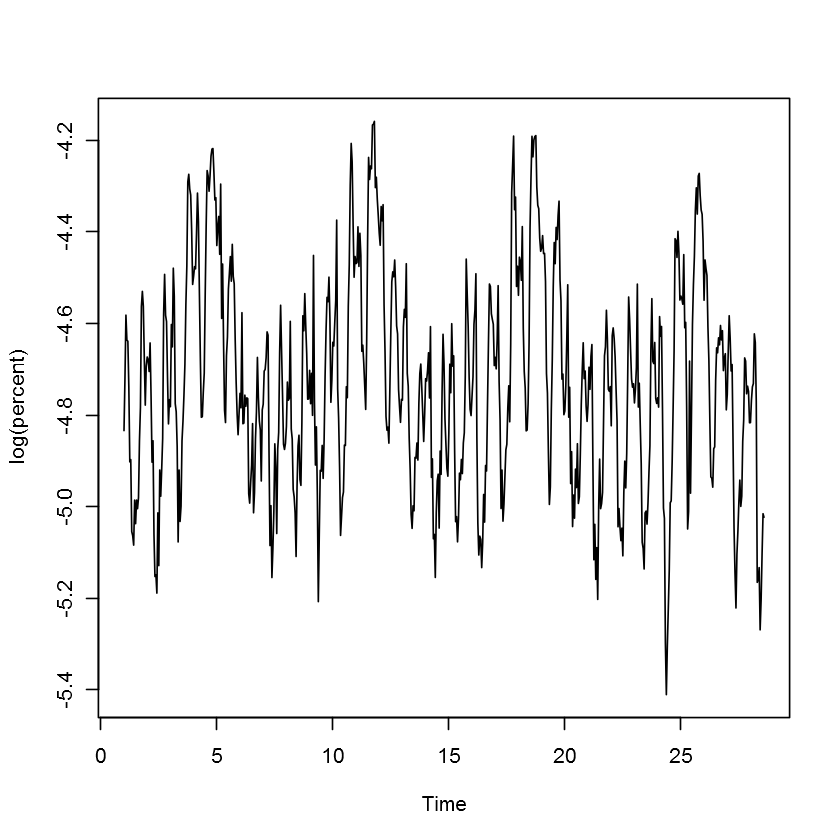

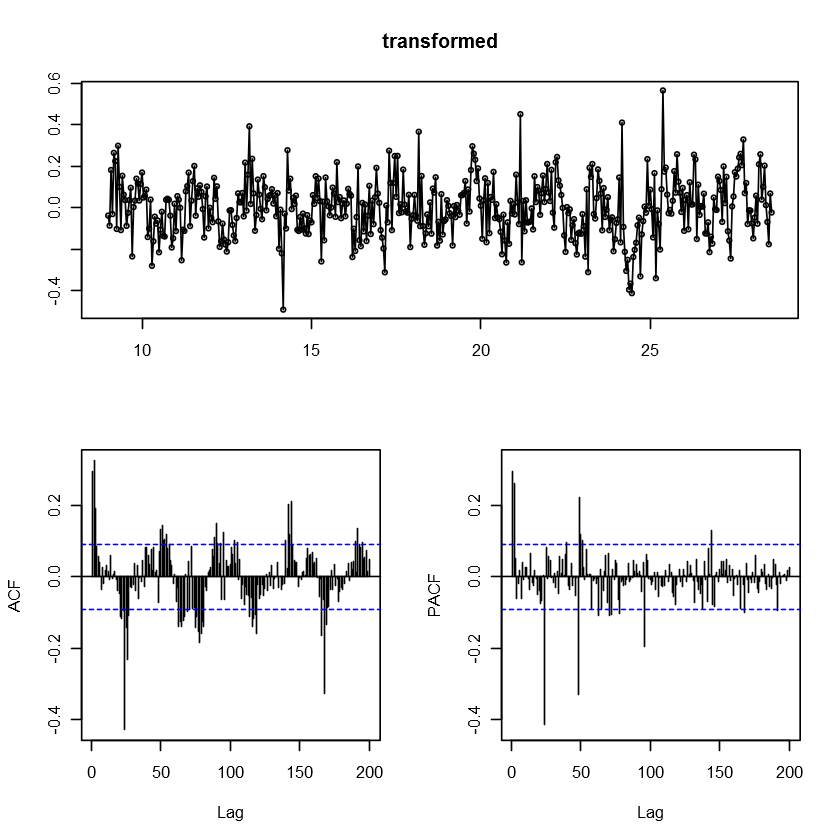

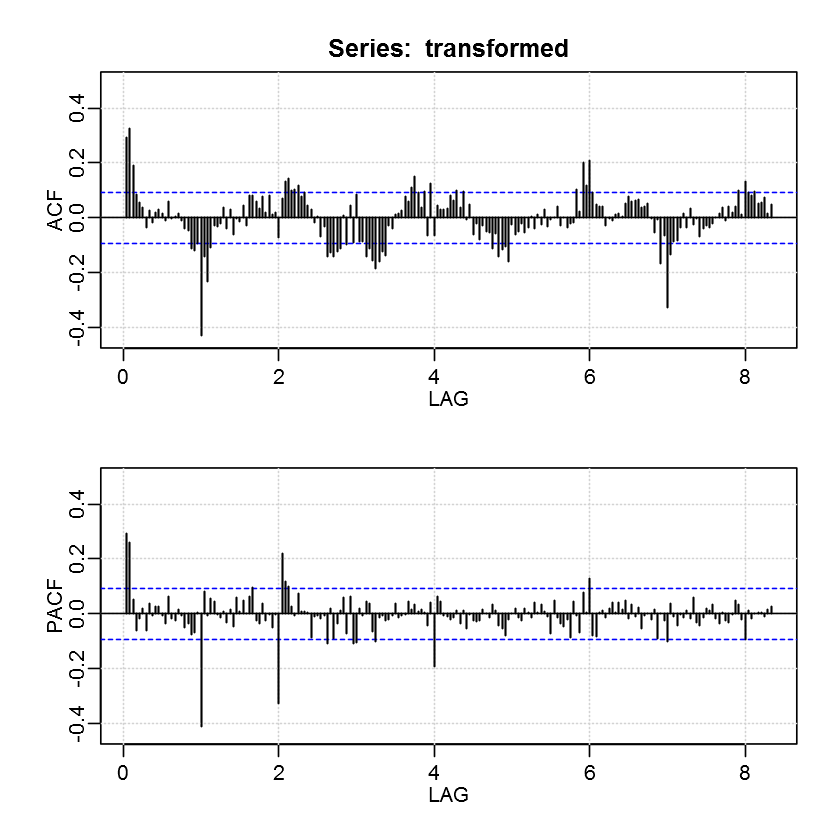

In [114]:
fit = dsarima(ts_cas, ts_total)

In [115]:
fit

Series: transformed 
ARIMA(2,0,2)(2,0,1)[24] with zero mean     

Coefficients:
          ar1     ar2     ma1      ma2     sar1     sar2     sma1
      -0.1084  0.6954  0.4045  -0.3781  -0.1683  -0.2284  -0.6049
s.e.   0.1463  0.1292  0.1620   0.1176   0.0953   0.0720   0.0986

sigma^2 estimated as 0.01015:  log likelihood=405.08
AIC=-794.17   AICc=-793.86   BIC=-760.93

png 
  2

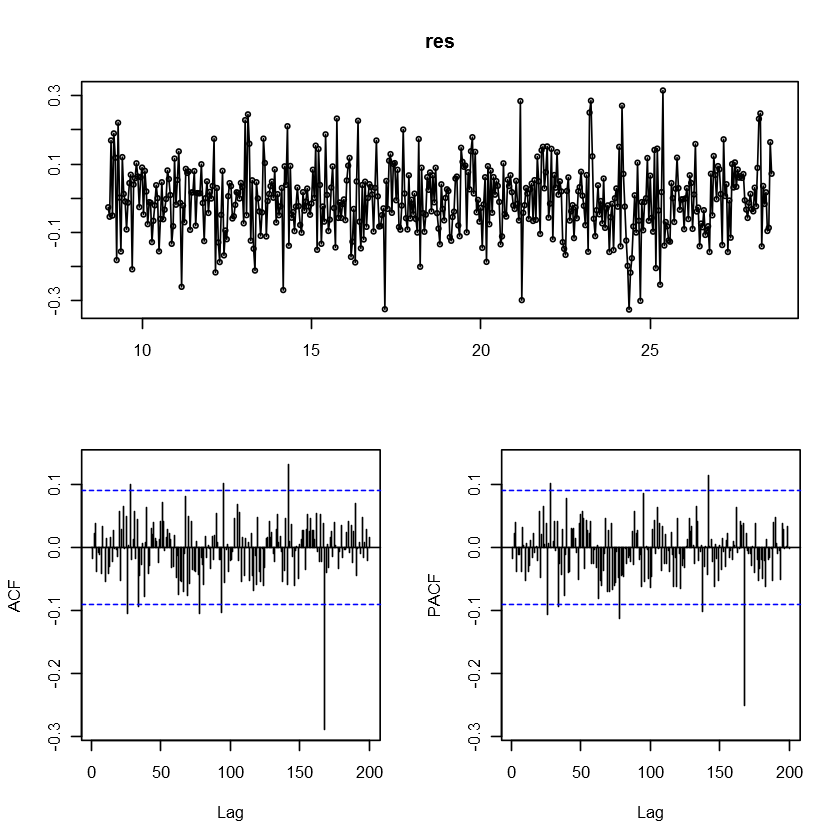

In [117]:
residual_analysis(fit$residuals)

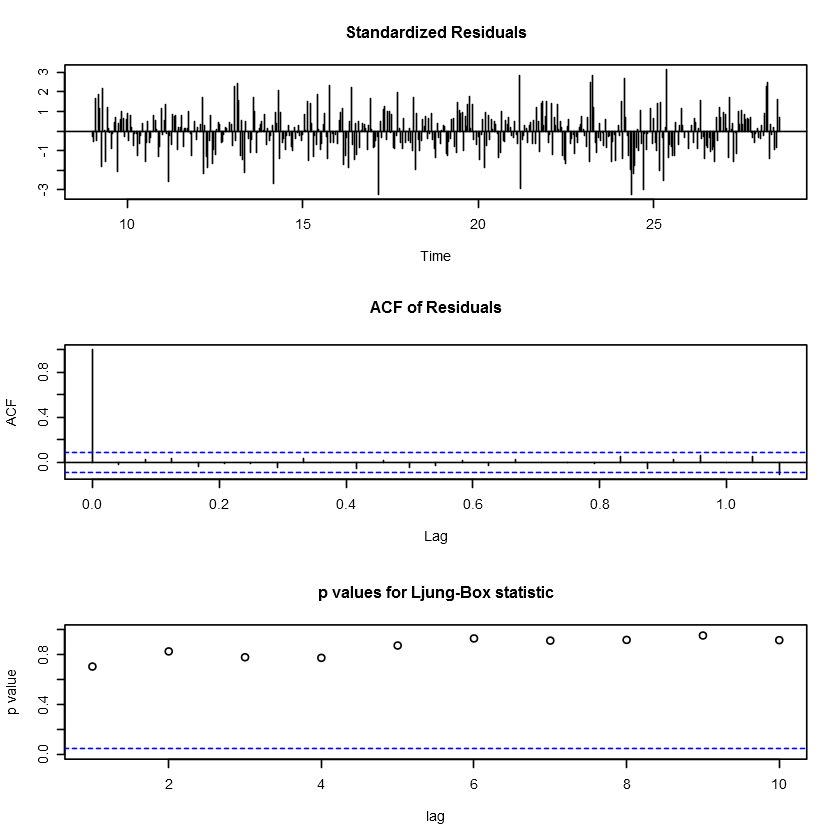

In [116]:
tsdiag(fit)

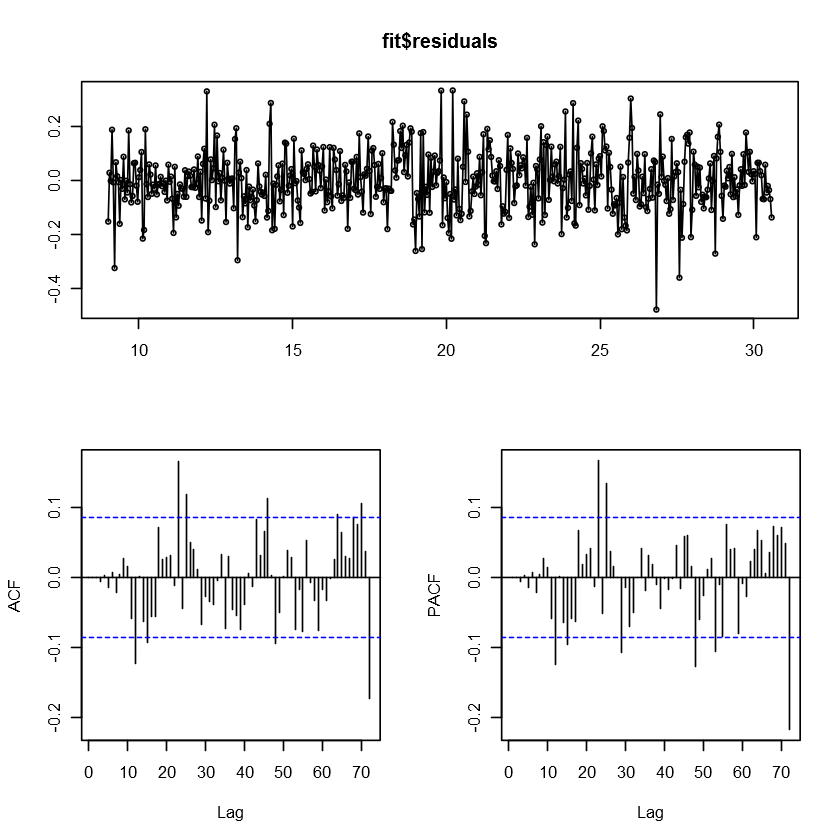

In [37]:
tsdisplay(fit$residuals)

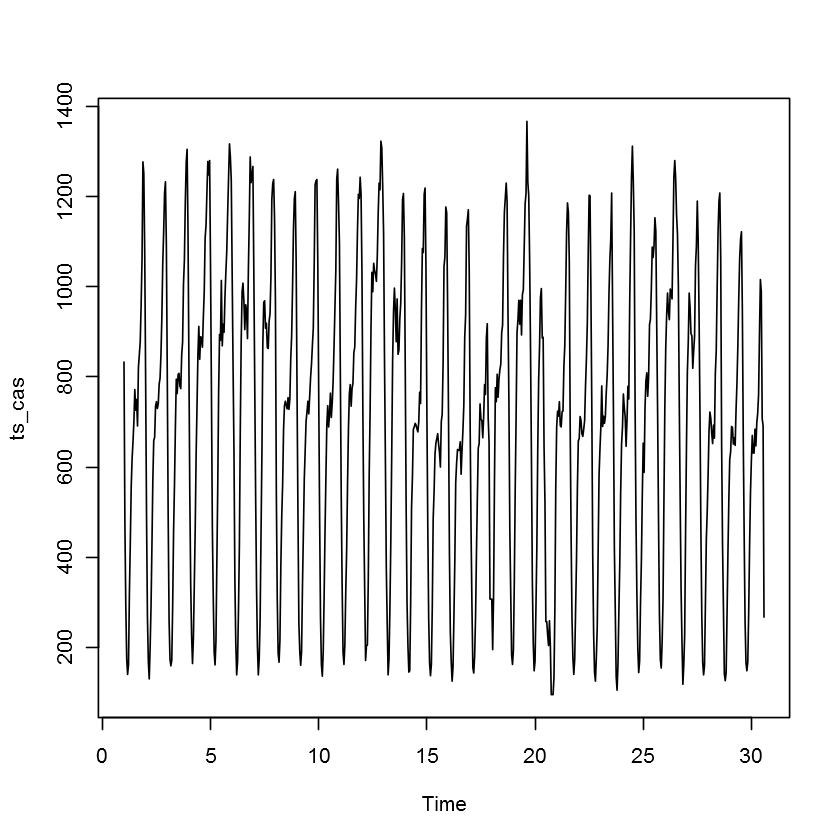

In [96]:
plot(ts_cas, type='l')

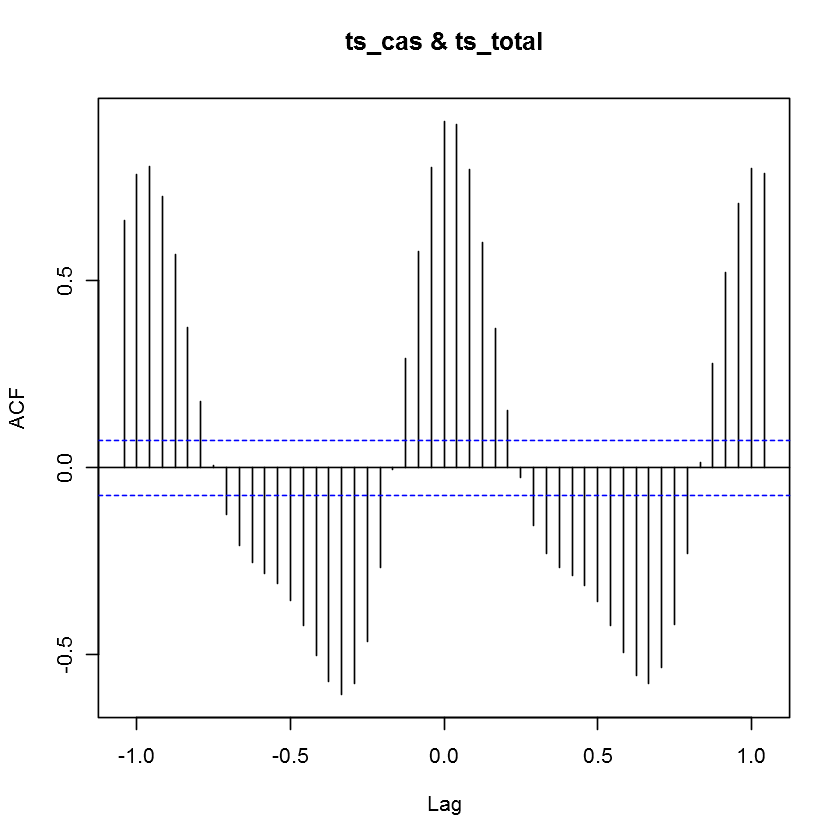

In [97]:
ccf(ts_cas, ts_total)

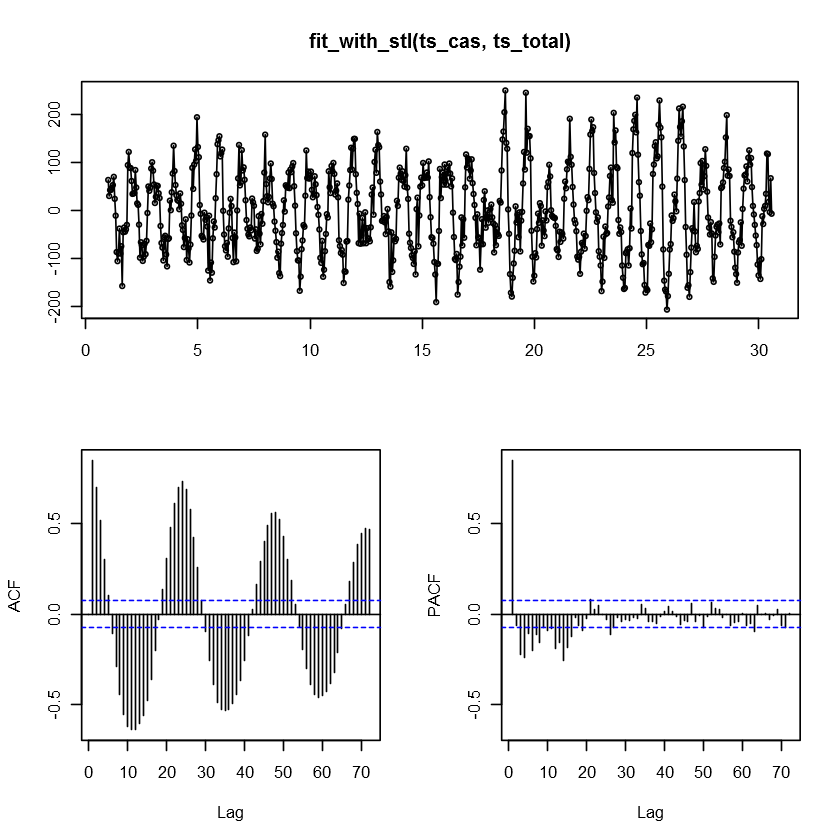

In [98]:
tsdisplay(fit_with_stl(ts_cas, ts_total))

In [84]:
fit = lm(ts_cas~ts_total)

In [86]:
summary(fit)


Call:
lm(formula = ts_cas ~ ts_total)

Residuals:
    Min      1Q  Median      3Q     Max 
-235.96  -91.06   -4.28   46.24  446.91 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) -21.410247  11.771520  -1.819   0.0694 .  
ts_total      0.008924   0.000194  46.010   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 132.1 on 709 degrees of freedom
Multiple R-squared:  0.7491,	Adjusted R-squared:  0.7488 
F-statistic:  2117 on 1 and 709 DF,  p-value: < 2.2e-16


In [87]:
res = ts(fit$residuals, frequency=24)

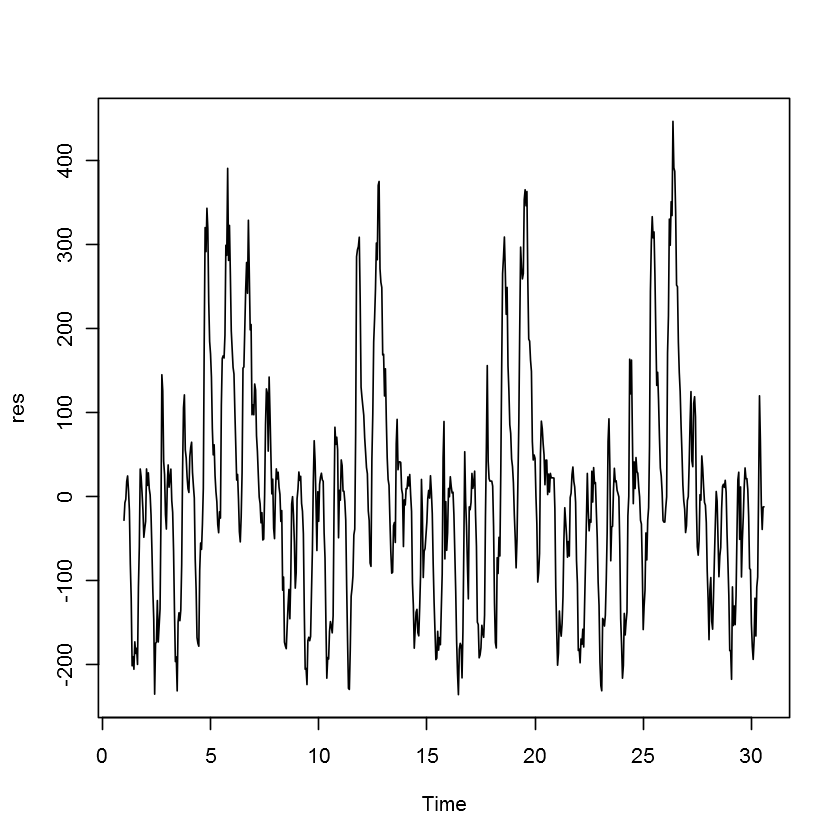

In [88]:
plot(res, type='l')

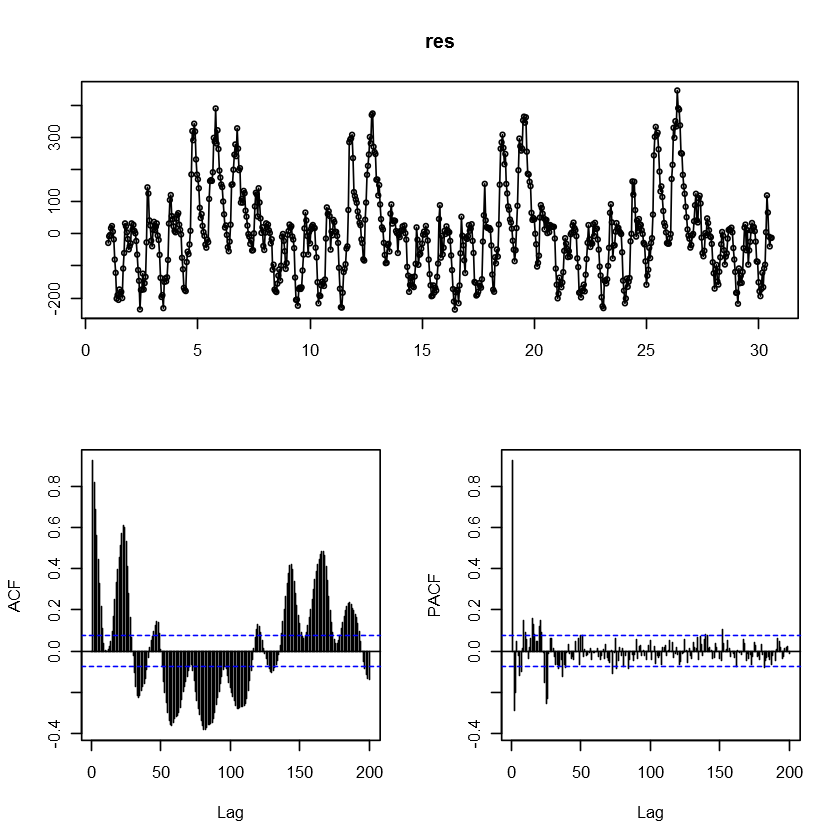

In [89]:
tsdisplay(res, lag.max=200)

In [56]:
fit = stl(res, s.window='periodic')

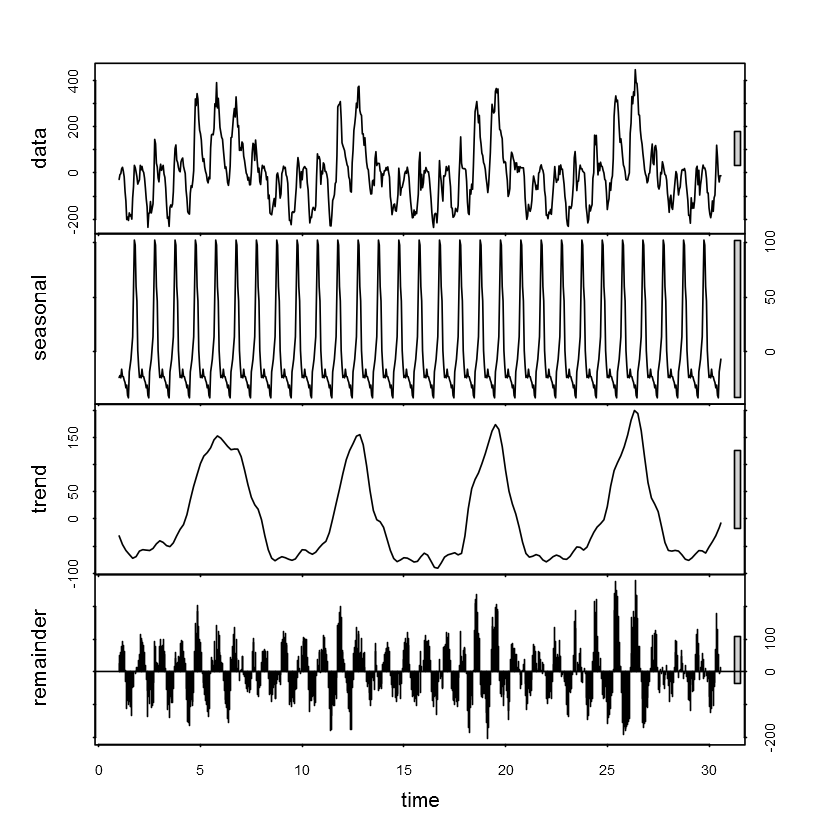

In [58]:
plot(fit)

In [59]:
remainder = fit$time.series[,'remainder']

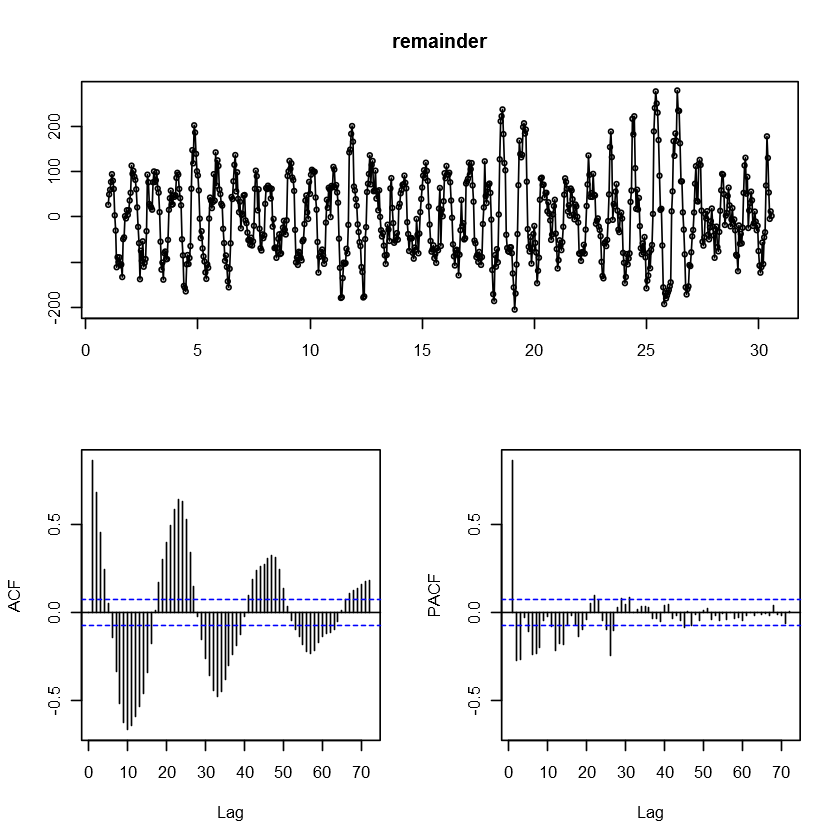

In [60]:
tsdisplay(remainder)

In [41]:
no_daily = fit$time.series[,'trend'] + fit$time.series[,'remainder']

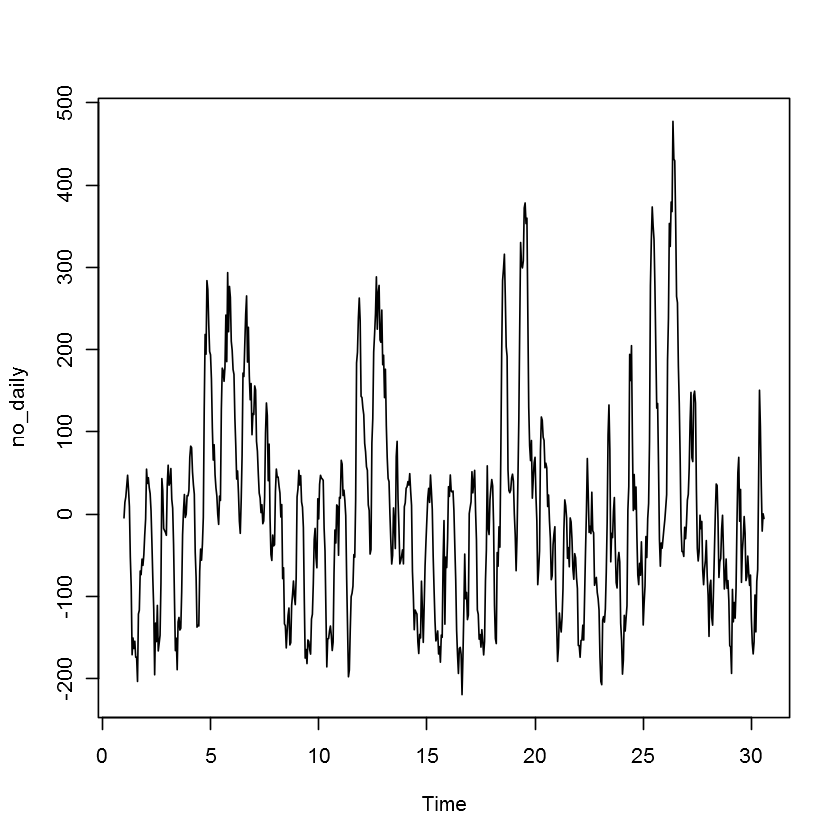

In [42]:
plot(no_daily)

In [63]:
arima_fit = auto.arima(remainder)

In [64]:
arima_fit

Series: remainder 
ARIMA(2,0,2)(2,0,2)[24] with zero mean     

Coefficients:
         ar1      ar2      ma1     ma2    sar1    sar2     sma1     sma2
      1.8302  -0.9133  -1.1331  0.1743  0.4461  0.2214  -0.2145  -0.1199
s.e.  0.0170   0.0173   0.0454  0.0481  0.7301  0.5836   0.7353   0.4268

sigma^2 estimated as 1267:  log likelihood=-3548.57
AIC=7115.14   AICc=7115.4   BIC=7156.24

In [65]:
library(astsa)


Attaching package: 'astsa'

The following object is masked from 'package:forecast':

    gas



ACF  PACF
 [1,]  0.00  0.00
 [2,]  0.03  0.03
 [3,] -0.12 -0.12
 [4,] -0.04 -0.04
 [5,]  0.05  0.06
 [6,]  0.08  0.07
 [7,]  0.07  0.05
 [8,] -0.05 -0.04
 [9,] -0.05 -0.03
[10,] -0.03 -0.01
[11,]  0.08  0.07
[12,]  0.04  0.02
[13,]  0.06  0.04
[14,] -0.06 -0.04
[15,] -0.05 -0.04
[16,]  0.02  0.03
[17,]  0.08  0.06
[18,]  0.07  0.04
[19,]  0.01  0.01
[20,] -0.07 -0.05
[21,] -0.06 -0.03
[22,] -0.02 -0.02
[23,]  0.13  0.10
[24,]  0.00 -0.03
[25,]  0.24  0.24
[26,]  0.01  0.06
[27,] -0.09 -0.09
[28,] -0.10 -0.09
[29,] -0.03 -0.04
[30,]  0.00 -0.06
[31,]  0.02  0.00
[32,] -0.04 -0.05
[33,] -0.09 -0.06
[34,] -0.06 -0.05
[35,] -0.03 -0.04
[36,]  0.09  0.03
[37,]  0.01  0.01

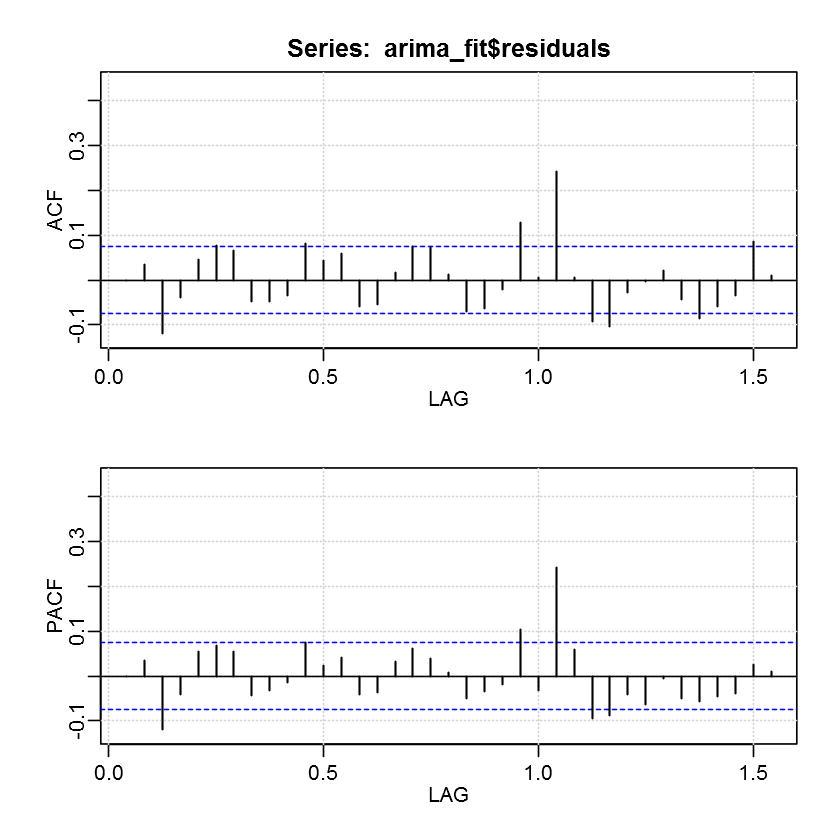

In [67]:
acf2(arima_fit$residuals)

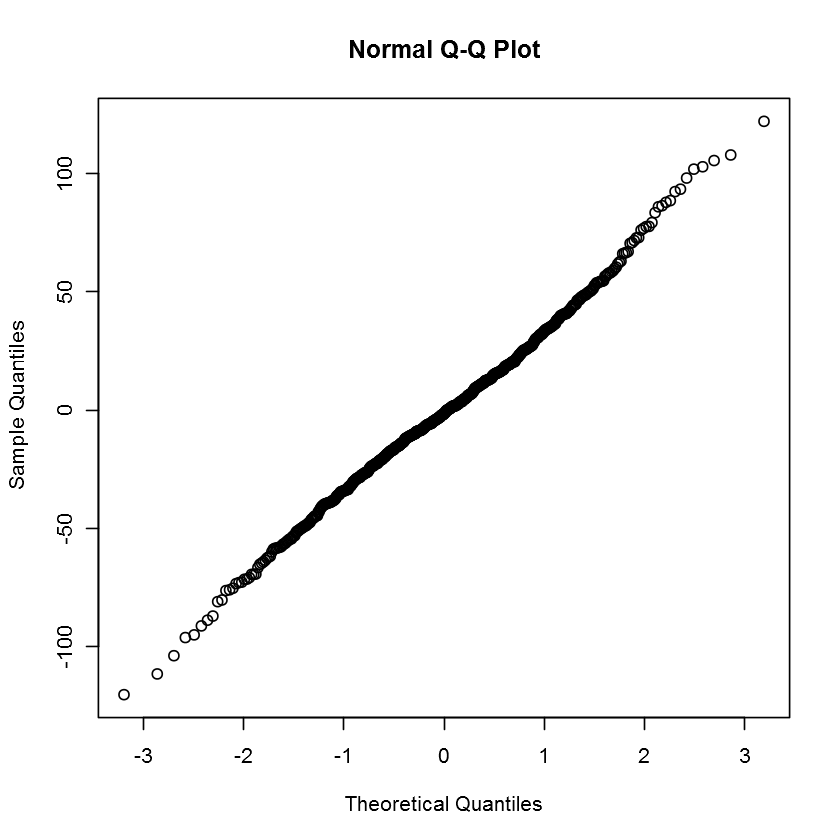

In [69]:
qqnorm(arima_fit$residuals)

In [70]:
cas_file <- 'E:/summary/june_casual.csv'
cas <- read.csv(cas_file)
total_file <- 'E:/summary/june_total.csv'
total <- read.csv(total_file)
df_total =data.frame(total)
df_cas = data.frame(cas)
missing = df_total[,'total']<5000
df_total[missing, 'total'] <- NA
df_cas[missing, 'casual'] <-NA
ts_total = ts(na.locf(df_total[,'total']))
ts_cas = ts(na.locf(df_cas[, 'casual']), frequency=24)

In [71]:
missing = df_total[,'total']<5000
df_total[missing, 'total'] <- NA
df_cas[missing, 'casual'] <-NA

In [84]:
ts_total = ts(na.locf(df_total[,'total']))
ts_cas = ts(na.locf(df_cas[, 'casual']), frequency=24)

In [76]:
length(ts_cas)

[1] 724

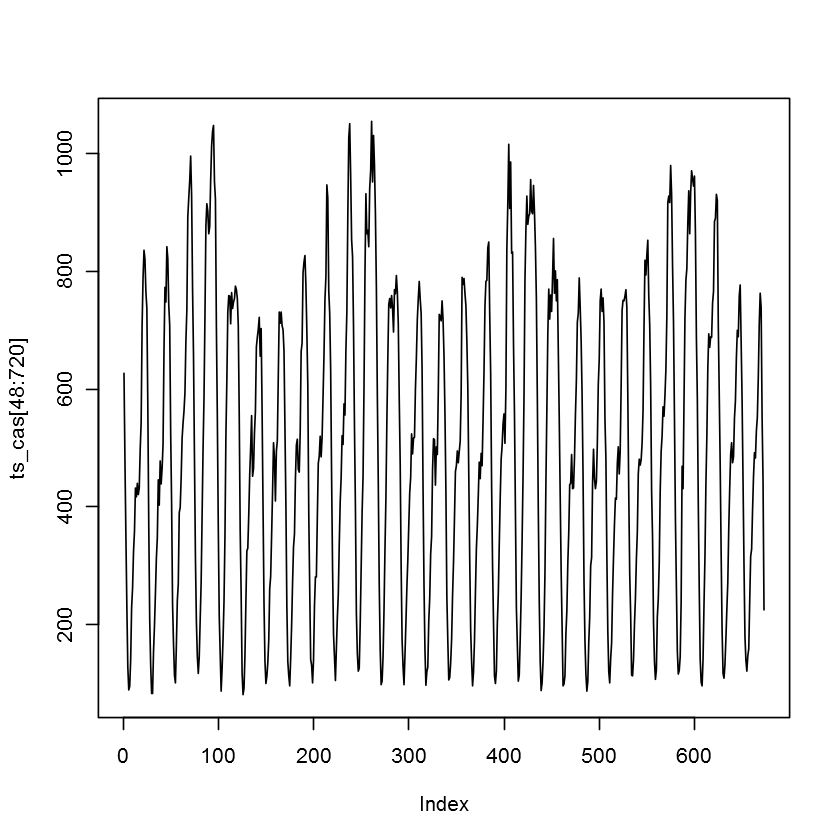

In [85]:
plot(ts_cas[48:720], type='l')

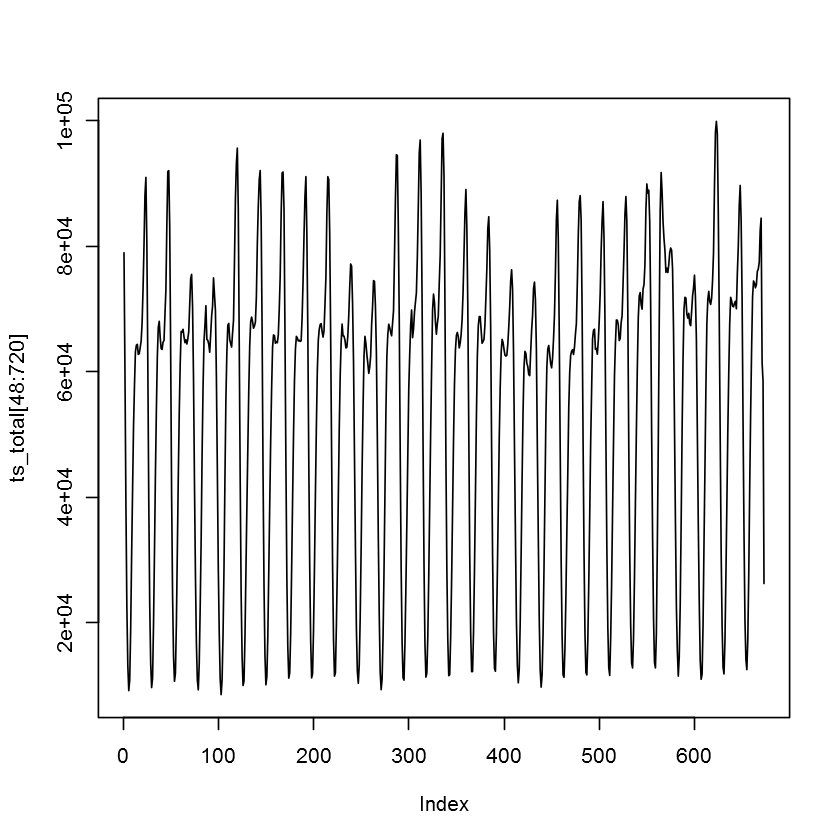

In [86]:
plot(ts_total[48:720], type='l')

In [81]:
fit = lm(ts_cas~ts_total)

In [82]:
res = ts(fit$residuals, frequency=24)

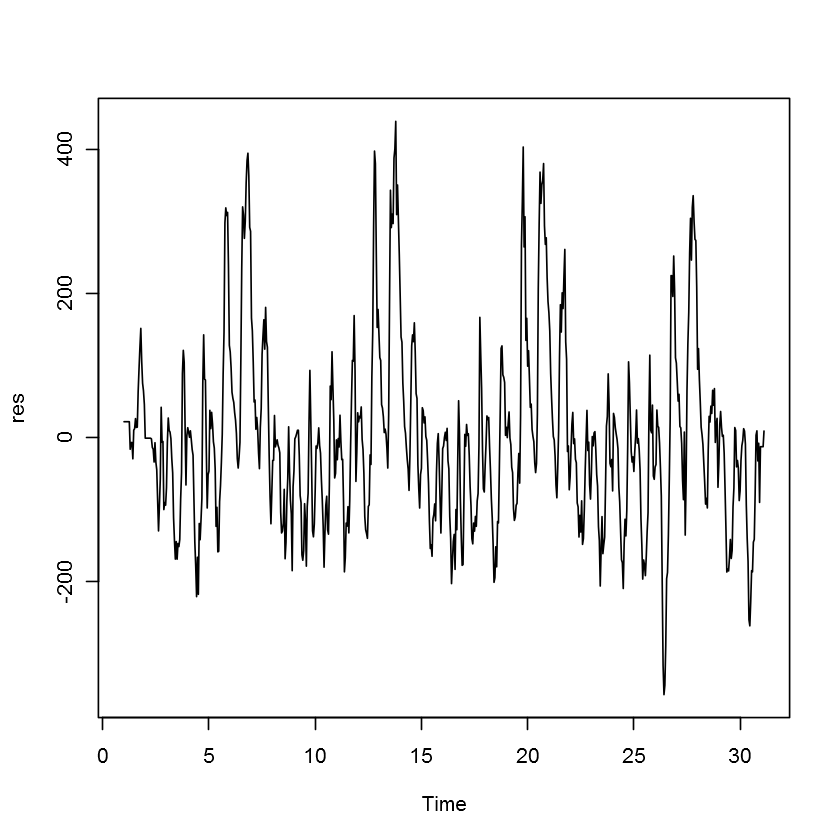

In [83]:
plot(res)

In [87]:
fit = stl(res, s.window='periodic')

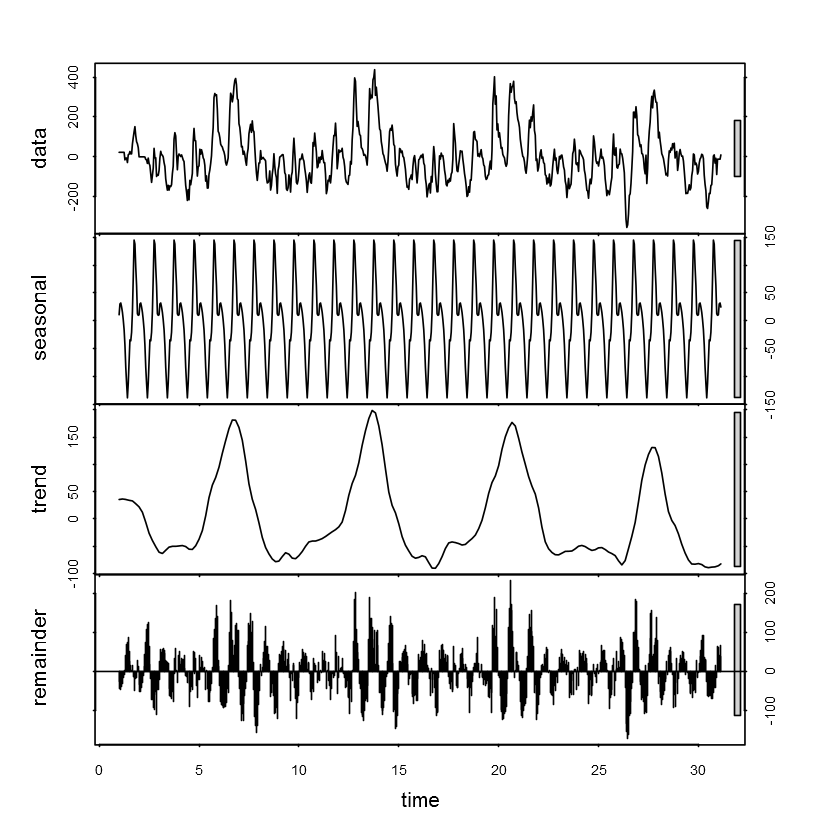

In [88]:
plot(fit)

In [91]:
remainder = fit$time.series[,'remainder']

In [92]:
arima_fit = auto.arima(remainder)

In [96]:
arima_fit2 = arima(remainder, order=c(2, 0, 2), seasonal=list(order=c(2, 0, 2), period=24))

In [97]:
arima_fit2


Call:
arima(x = remainder, order = c(2, 0, 2), seasonal = list(order = c(2, 0, 2), 
    period = 24))

Coefficients:
         ar1      ar2      ma1     ma2   sar1     sar2     sma1    sma2
      1.7900  -0.8817  -1.2306  0.2845  1.259  -0.9905  -1.3153  0.9995
s.e.  0.0223   0.0243   0.0460  0.0563  0.017   0.0068   0.0469  0.0549
      intercept
         0.0645
s.e.     0.6378

sigma^2 estimated as 943.2:  log likelihood = -3543.93,  aic = 7107.85

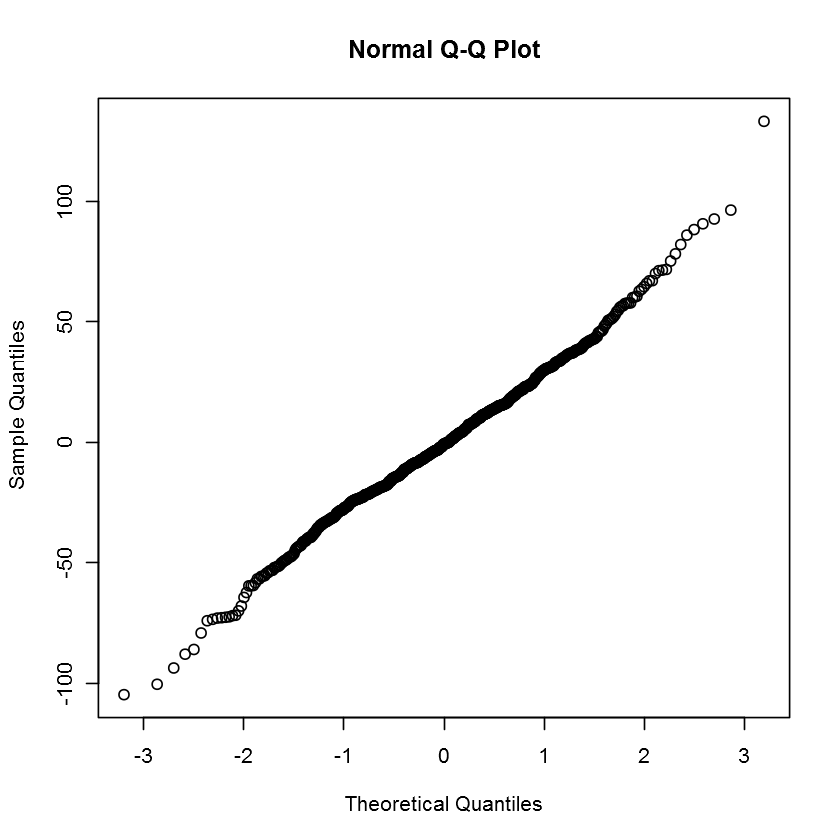

In [98]:
qqnorm(arima_fit2$residuals)

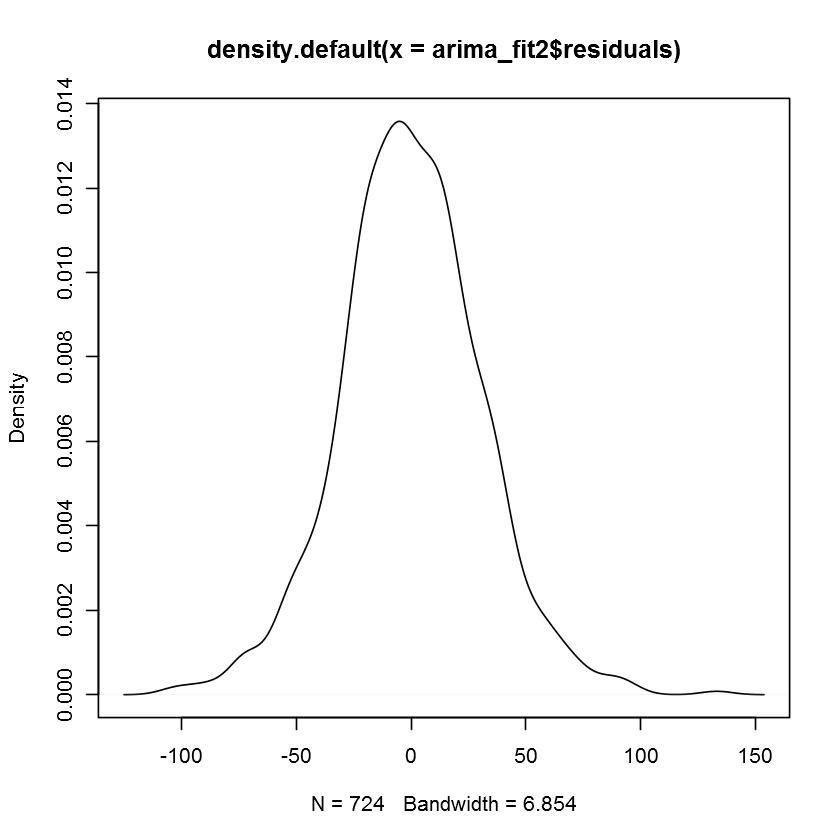

In [99]:
plot(density(arima_fit2$residuals))

ACF  PACF
 [1,]  0.00  0.00
 [2,]  0.01  0.01
 [3,] -0.01 -0.01
 [4,]  0.02  0.02
 [5,] -0.04 -0.04
 [6,]  0.00  0.00
 [7,]  0.03  0.03
 [8,]  0.04  0.04
 [9,]  0.04  0.04
[10,]  0.00  0.00
[11,] -0.01 -0.02
[12,] -0.02 -0.02
[13,]  0.00  0.00
[14,]  0.00  0.00
[15,] -0.02 -0.02
[16,]  0.02  0.01
[17,]  0.05  0.04
[18,]  0.06  0.06
[19,]  0.03  0.04
[20,] -0.03 -0.03
[21,] -0.05 -0.06
[22,] -0.10 -0.10
[23,]  0.01  0.01
[24,]  0.01  0.02
[25,]  0.05  0.04
[26,] -0.05 -0.06
[27,]  0.04  0.03
[28,]  0.08  0.09
[29,] -0.11 -0.10
[30,] -0.12 -0.11
[31,] -0.01 -0.02
[32,] -0.09 -0.10
[33,] -0.03 -0.02
[34,] -0.09 -0.10
[35,] -0.02 -0.04
[36,]  0.01  0.01
[37,]  0.01  0.01

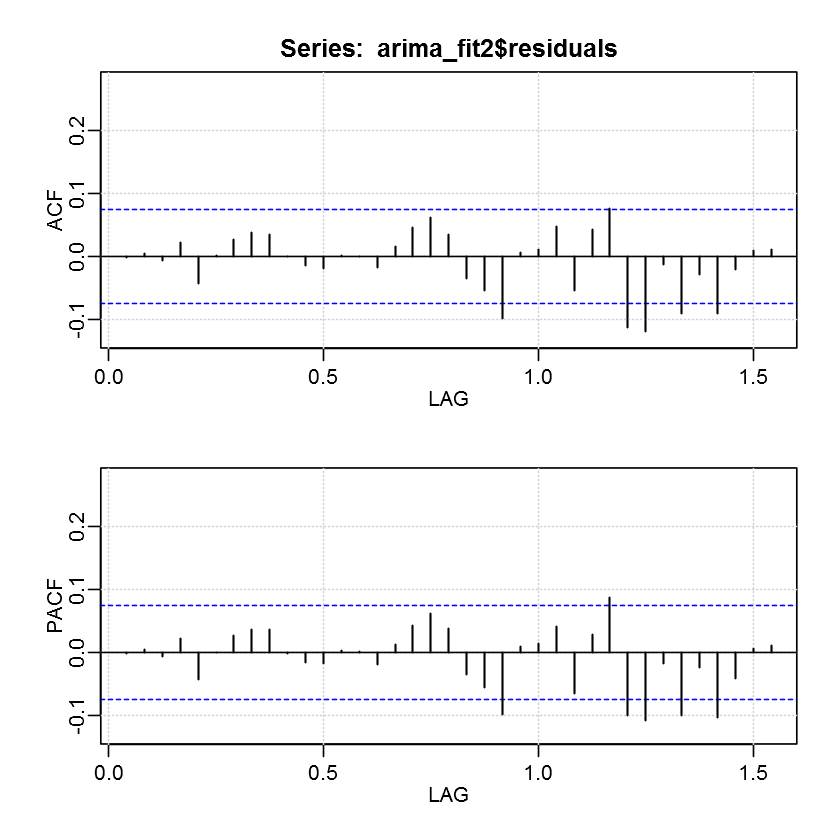

In [100]:
acf2(arima_fit2$residuals)

In [93]:
arima_fit

Series: remainder 
ARIMA(1,0,0)(2,0,1)[24] with zero mean     

Coefficients:
         ar1    sar1     sar2     sma1
      0.7662  0.7109  -0.2889  -0.6083
s.e.  0.0248  0.0792   0.0375   0.0783

sigma^2 estimated as 1370:  log likelihood=-3642.92
AIC=7295.84   AICc=7295.92   BIC=7318.76

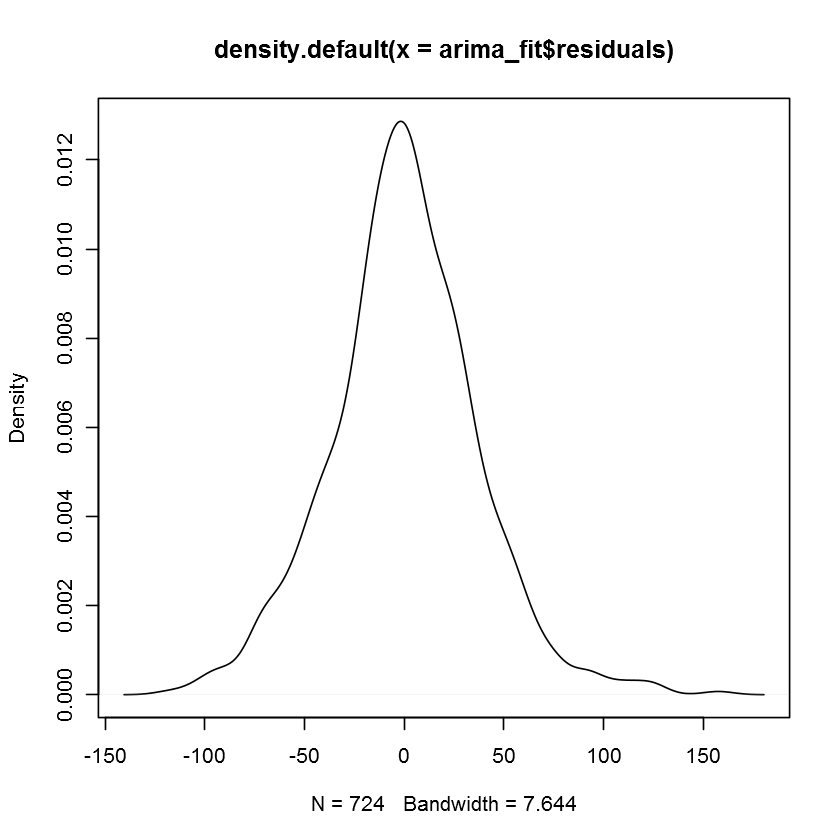

In [94]:
plot(density(arima_fit$residuals))

ACF  PACF
 [1,]  0.02  0.02
 [2,]  0.15  0.14
 [3,]  0.05  0.04
 [4,]  0.00 -0.02
 [5,] -0.10 -0.11
 [6,] -0.12 -0.12
 [7,] -0.13 -0.10
 [8,] -0.13 -0.09
 [9,] -0.15 -0.11
[10,] -0.16 -0.15
[11,] -0.16 -0.16
[12,] -0.13 -0.15
[13,] -0.08 -0.12
[14,] -0.03 -0.11
[15,]  0.01 -0.10
[16,]  0.05 -0.10
[17,]  0.13 -0.03
[18,]  0.13 -0.03
[19,]  0.12 -0.04
[20,]  0.10 -0.06
[21,]  0.06 -0.09
[22,]  0.00 -0.14
[23,]  0.11  0.03
[24,] -0.01 -0.04
[25,]  0.11  0.09
[26,] -0.06 -0.04
[27,]  0.01  0.02
[28,]  0.01  0.11
[29,] -0.15 -0.05
[30,] -0.17 -0.11
[31,] -0.06  0.01
[32,] -0.13 -0.05
[33,] -0.05  0.00
[34,] -0.08 -0.06
[35,]  0.00 -0.03
[36,]  0.04  0.02
[37,]  0.07  0.04

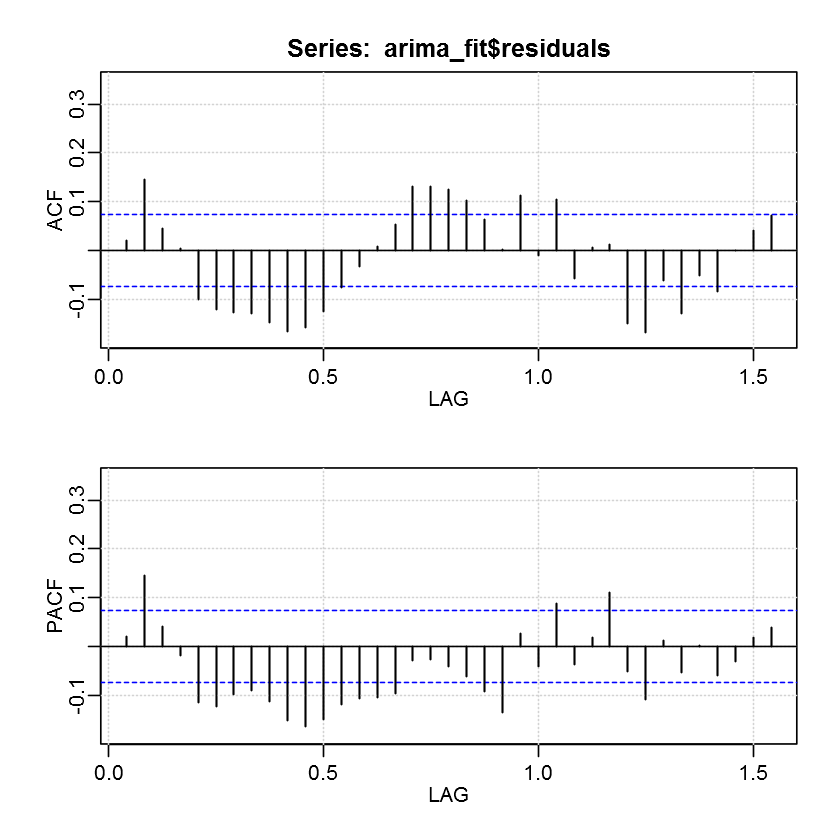

In [95]:
acf2(arima_fit$residuals)